In [1]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: dataset/short_milan_processed_2013-11-01.txt  
  inflating: dataset/short_milan_processed_2013-11-02.txt  
  inflating: dataset/short_milan_processed_2013-11-03.txt  
  inflating: dataset/short_milan_processed_2013-11-04.txt  
  inflating: dataset/short_milan_processed_2013-11-05.txt  
  inflating: dataset/short_milan_processed_2013-11-06.txt  
  inflating: dataset/short_milan_processed_2013-11-07.txt  
  inflating: dataset/short_milan_processed_2013-11-08.txt  
  inflating: dataset/short_milan_processed_2013-11-09.txt  
  inflating: dataset/short_milan_processed_2013-11-10.txt  
  inflating: dataset/short_milan_processed_2013-11-11.txt  
  inflating: dataset/short_milan_processed_2013-11-12.txt  
  inflating: dataset/short_milan_processed_2013-11-13.txt  
  inflating: dataset/short_milan_processed_2013-11-14.txt  
  inflating: dataset/short_milan_processed_2013-11-15.txt  
  inflating: dataset/short_milan_processed_2013-11-16.txt  
  inflating: datas

In [2]:
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)
#F: the lines above are used to obtain reproducible results with tensorflow.keras libraries used next in the lab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import plot_model


# Task 1a)
Define function *load_dataset()* that takes in input cell ID, start day, number of days and type of traffic to be considered, and returns a pandas dataframe with data retrieved from proper source files (details below)

**N.B.1 Traffic data should be aggregated per 1-hour period (now they are collected every 10 mins)**

**N.B.2 Indexes of days must correspond to the selected days (e.g., indexes 36-40 if selecting days Dec. 6th - 10th)**

Hints:
- Note that source files are named as "short_milan_processed_yyyy-mm-dd.txt"
- Available data is collected between 2013-11-01 and 2013-12-31 (61 days in total)

In [3]:
def load_dataset(cell_id, start_day, num_days, traffic_type):
#Inputs: - cell_id: id of the square cell to consider (an integer in [1-20] or [4991-5010] or [9981-10000])
#        - start_day: first day to include in the dataframe (an integer in [1,61])
#        - num_days: number of consecutive days to include in the dataframe, starting from start_day
#        - traffic_type: either 1) Received SMS, 2) Sent SMS, 3) Incoming Calls, 4) Outgoing Calls, 5) Internet
#Output: - df: dataframe with loaded traffic info (rows are days, columns are hours)
#          Indexes of days must correspond to the selected days
#          (e.g., indexes 36-40 if selecting days Dec. 6th - 10th)

    #F: initialize df with num_days rows and 24 columns (one per hour); cells in df contain zeros in the initialization
    df = pd.DataFrame(np.zeros([num_days, 24]), index = range(start_day,start_day+num_days), columns = range(24))

    for d in range(start_day,start_day+num_days):
        #F: this part is needed for days of December, that are indexed with 31-61,
        #   but in file names they appear as "short_milan_processed_2013-12-dd.txt"
        if d >= 31:
            day = str(d - 30).zfill(2) #F: day is expressed always with two digits in file names
            month = '12'
        else:
            day = str(d).zfill(2) #F: day is expressed always with two digits in file names
            month = '11'

        #print('processing file dataset/short_milan_processed_2013-' + str(month) + '-' + str(day) + '.txt')
        with open('dataset/short_milan_processed_2013-' + month + '-' + day + '.txt', 'r') as f:

            hour = 0
            counter = 0 #F: will be used to aggregate 10-minutes traffic into hourly traffic

            #F: now you should scan file f and fill the dataframe df
            #   with traffic info aggregated per hour (one row = one day, one column = one hour)

            ############# ADD YOUR CODE BELOW #############

            for line in f:
                if int(line.split()[0]) == cell_id:
                    #print(line.split()[traffic_type+1])
                    df.loc[d, hour] += float(line.split()[traffic_type+1]) #F: +1 as we input traffic_type as a number in [1,5] but corresponding columns in the src file are in [2,6]
                    counter += 1

                    # 6 times 10 minutes - one hour
                    if counter == 6:
                        hour += 1
                        counter = 0

                if int(line.split()[0]) > cell_id:
                    break #F: assuming cell IDs are increasing and ordered in the source files, when we have a new cell_id we stop soon instead of arriving to EOF and pass to the next day d

    return df


# Task 1b)

Call function *load_dataset()* for week Dec 2nd (Monday) - Dec 8th (Sunday) for cell ID = 3 considering Internet traffic, then display dataframe object in tabular form

(code is already given below)

In [4]:
cell = 3
start_d = 32
num_d = 7
traffic_t = 5

dataframe = load_dataset(cell, start_d, num_d, traffic_t)

dataframe

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
32,55.560594,49.568379,39.700737,38.161090,36.137046,38.432246,46.179424,57.859469,52.696863,45.859077,...,57.721614,59.159070,66.118096,67.281443,72.982687,86.196472,92.734066,81.109253,88.663862,64.296856
33,51.270115,49.856398,45.644236,42.199057,36.384711,33.515705,47.304401,58.780178,52.744205,61.983305,...,60.033429,62.184259,68.179293,70.263213,74.068190,81.969702,86.819221,85.766811,89.472618,62.074336
34,61.046252,47.833819,47.067196,36.016166,31.364266,36.354097,47.467844,56.528149,53.667258,52.654684,...,60.338401,63.774202,67.964699,74.936147,81.206146,86.419903,87.111658,100.552459,91.121896,66.771121
35,60.846063,51.661429,40.679023,38.758770,33.022719,38.710436,49.928087,56.918719,52.866572,56.532455,...,63.241110,71.288841,72.140565,71.377866,79.436665,89.419032,87.671441,88.320385,78.125274,64.137855
36,53.486007,49.352207,40.949818,36.198185,33.945772,36.223636,46.311147,61.111922,59.704471,55.145789,...,59.955586,67.526787,79.886751,76.492273,78.783303,88.223109,91.859955,82.641889,84.329603,77.446933
37,58.997251,48.776801,43.377959,38.467685,37.563569,53.405300,39.549852,50.374114,64.941606,81.121539,...,78.838760,70.754261,66.607295,73.128049,78.636588,84.529431,79.678176,77.600523,79.993248,82.160557
38,68.333627,60.776944,52.663792,48.541061,42.859002,36.009043,41.799559,48.598480,57.296259,70.010881,...,96.932566,95.622392,90.354642,88.645038,93.141251,91.487352,89.833093,84.331452,78.335562,77.983496


# Task 1c)

Define function *plot_trace()* that takes in input cell ID, start day, number of days and type of data traffic to be considered, calls function *load_dataset()*, plots and saves a figure with traffic trace vs time

Hint:
- use *numpy.reshape()* to vectorize a matrix: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html

(code is already given below)

In [5]:
def plot_trace(cell_id, start_day, num_days, traffic_type, alltraces=False):
#Inputs: - cell_id: id of the square cell to consider (an integer in [1-20] + [4991-5010] + [9981-10000])
#        - start_day: first day to include in the dataframe (an integer in [1,61])
#        - num_days: number of consecutive days to include in the dataframe, starting from start_day
#        - traffic_type: either 1) Received SMS, 2) Sent SMS, 3) Incoming Calls, 4) Outgoing Calls, 5) Internet
#        - alltraces: if True, the function must plot and save a figure with all traffic types on the same graph
#Output: - Figure(s) with required traffic trace(s) saved in subfolder "Preprocessing"

    dataf = load_dataset(cell_id, start_day, num_days, traffic_type)
    xvalues = np.array(list(range(0,num_days*24,1)))
    xt = xvalues[np.where(xvalues%24==0)]
    trace = dataf.to_numpy().reshape(1,-1)[0]
    print('plotting traces for cell n. {}'.format(cell_id))
    traffictypes = ['Rec_SMS', 'Sent_SMS', 'Inc_Calls', 'Out_Calls', 'Internet']
    t_type = traffictypes[traffic_type-1]

    plt.title('Cell n. {}'.format(cell_id))
    plt.xlabel(r'Hours')
    plt.ylabel(r'Traffic (CDR)')
    plt.xticks(xt)
    plt.grid(axis='x')
    plt.plot(xvalues, trace, label = '{} traffic cell {}, days {}-{}'.format(t_type, cell_id, start_day, str(start_day+num_days-1)))
    plt.legend(loc="lower right")

    res_folder = 'Preprocessing'
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)

    plt.savefig(res_folder + '/{}_cell{}_days_{}-{}.png'.format(t_type, cell_id, start_day, str(start_day+num_days-1)))
    plt.show()

    #plt.figure()
    if alltraces:
        #print('plotting all traces....')
        plt.title('Cell n. {}'.format(cell_id))
        plt.xlabel(r'Hours')
        plt.ylabel(r'Traffic (CDR)')
        plt.xticks(xt)
        plt.grid(axis='x')
        for ttype in range(1,6):
            df = load_dataset(cell_id, start_day, num_days, ttype)
            tr = df.to_numpy().reshape(1,-1)[0]
            #print(xvalues)
            #print(tr)
            plt.plot(xvalues, tr, label = '{} traffic cell {}, days {}-{}'.format(traffictypes[ttype-1], cell_id, start_day, str(start_day+num_days-1)))

        plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
        plt.savefig(res_folder + '/all_cell{}_days_{}-{}.png'.format(cell_id, start_day, str(start_day+num_days-1)), bbox_inches='tight')
        plt.show()



# Task 1d)

Call function *plot_trace()* for week Dec 2nd (Monday) - Dec 8th (Sunday) for cell IDs = 5, 4993, 9990, considering Internet traffic and plotting/saving also figures with all traffic types

(code is already given below)

plotting traces for cell n. 5


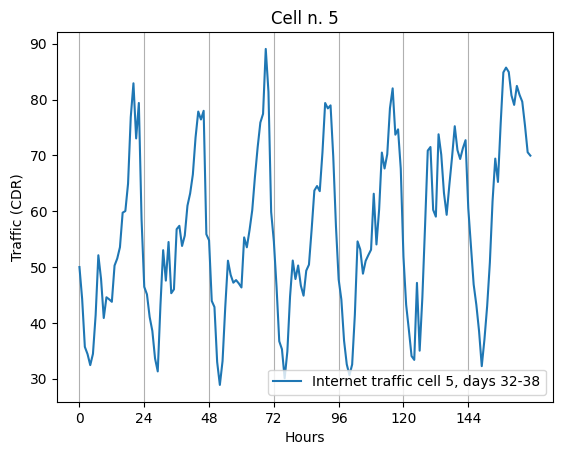

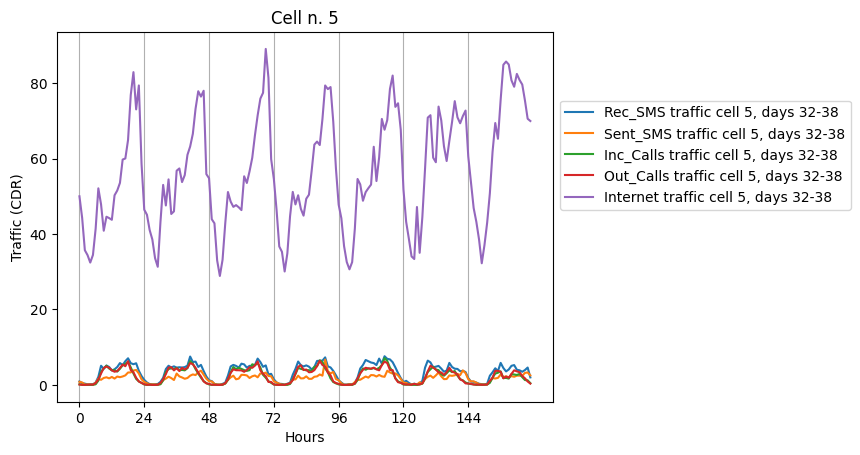

plotting traces for cell n. 4993


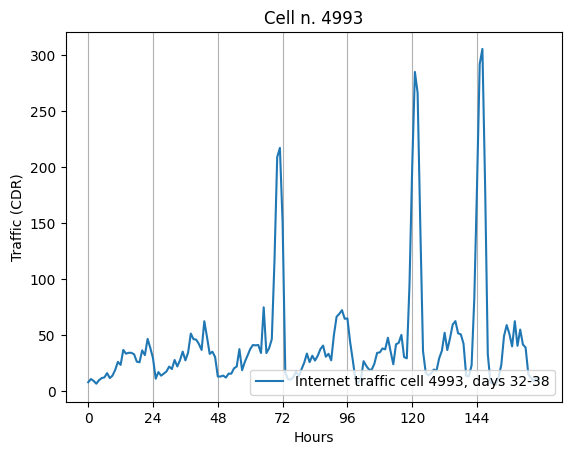

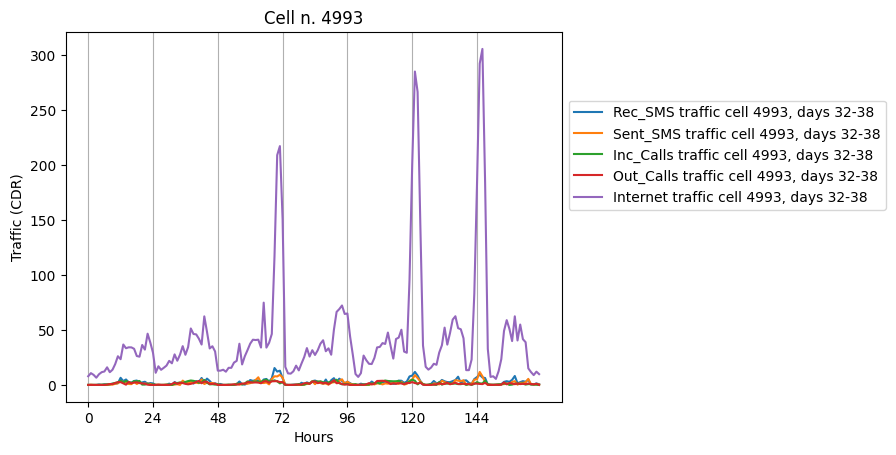

plotting traces for cell n. 9990


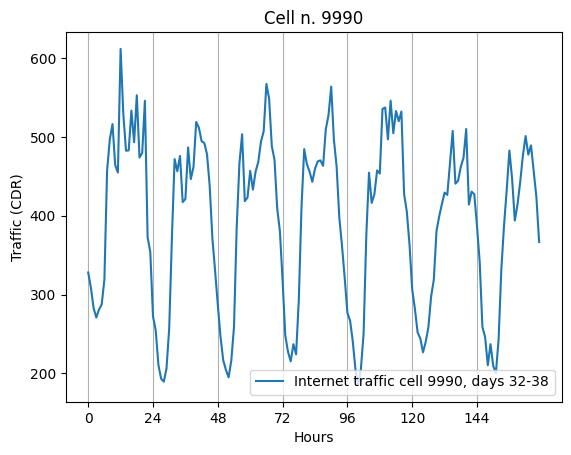

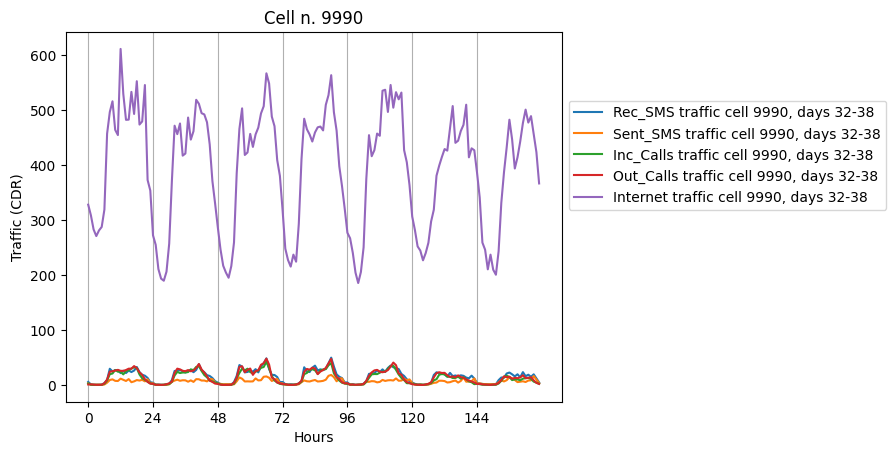

In [6]:
start_d = 32
num_d = 7
traffic_t = 5 #F: = 'Internet'
cells =[5, 4993, 9990]

#To plot traffic for all cell IDs:
#cells = list(range(1,21))
#range2 = list(range(4991,5011))
#range3 = list(range(9981,10001))
#cells.extend(range2)
#cells.extend(range3)

for cell in cells:
    plot_trace(cell, start_d, num_d, traffic_t,True)



# Task 2a)

Define function *generatedataset()* that takes in input a pandas dataframe and returns features matrix X and output y as numpy ndarrays (details below).

Hints:

- *pandas.DataFrame.from_dict* is used to create a dataframe starting from numpy arrays https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html


In [7]:
def generatedataset(dataset):
#Input:  - dataset: pandas dataframe with traffic profile as loaded in task 1
#Outputs: return X, y, Xdf, ydf,  where:
#         * X is the features matrix where each row is a given hour of a day, repeated for all the hours/days
#           in the dataset, and has the following features:
#               1) 'day_of_week' : 0=monday, 1=tuesday, ...
#               2) 'hour' : hour of the day
#               3) 'working' : binary, =1 if working, =0 if holiday
#               4) 'prev_week' : traffic value for the pevious week in the same day/hour
#               5) 'prev_day' : traffic value for the pevious day in the same hour
#         * y is the vector of outputs, i.e., it has traffic values for the current day/hour (that we want to predict based on X)
#         * Xdf, ydf are the pandas dataframe versions of X and y

    #F: the following array will be useful to identify holidays ID
    #F: holidays and sat/sun in the period Nov 1st-Dec 31st
    weekend_vect = np.array([1, 2, 3, 9, 10, 16, 17, 23, 24, 30, 31, 37, 38, 44, 45, 51, 52, 58, 59])

    #F: use the following lists to store features to be put in Xdf and X
    day_of_the_week = [] # FEATURE 1: DAY OF WEEK
    hour_vect = [] # FEATURE 2: HOUR OF DAY
    working_vect = [] # FEATURE 3: WORKING DAY / HOLIDAY (binary)
    prev_week_vect = [] # FEATURE 4: TRAFFIC IN PREVIOUS WEEK SAME DAY/HOUR
    prev_day_vect = [] # FEATURE 5: TRAFFIC IN PREVIOUS DAY SAME HOUR

############# ADD YOUR CODE BELOW #############

    # vector of days indexes in the dataset
    days_vect = list(dataset.index) #F: ---> [day1, day2, day3 ..., dayN]
    #print(days_vect)
    #print('...............')

    # vector of days indexes repeated for every hour
    day_hour_vect = [d for d in days_vect for h in range(24)] #F: ---> [day1(1), day1(2), ..., day1(24), day2(1), day2(2), ..., day2(24), ..., dayN(1), dayN(2), ..., dayN(24)]
    #F: (referred to the global dataset where day 1 is Nov. 1 and day 61 is Dec 31st)
    #print(day_hour_vect)
    #print('...............')
    # ------------------------------ FEATURE 1: DAY OF WEEK ---------------------------------
    day_of_the_week = [(day+3)%7 for day in day_hour_vect] #F: we want mondays as days 0, sundays as days 6; "+3" because day 1 is friday (that we want to convert into "4")
    #F: ---> if we start with friday (day 4) we get [4, 4, ..., 4(24 times), 5, 5, ..., 5(24 times), 6....(for all days in day_hour_vect)]
    #print(day_of_the_week)
    #print('...............')

    # vector of hours indexes, 0 to 23, repeated for every day in the dataset
    # ------------------------------ FEATURE 2: HOUR OF DAY ---------------------------------
    hour_vect = [h for d in days_vect for h in range(24)] #F: ---> [0(day1), 1(day1), ..., 23(day1), ..., 0(dayN), 1(dayN), ..., 23(dayN)]
    #print(hour_vect)
    #print('...............')

    # binary vector of working hours/days, =1 if that hour on that day is working, =0 if holiday
    # ------------------------------ FEATURE 3: WORKING DAY / HOLIDAY ---------------------------------
    working_vect = [0 if d in weekend_vect else 1 for d in days_vect for h in range(24)]
    #print(working_vect)
    #print('...............')

    # initialize vector with traffic from the pevious week same day/hour (here is only 1st day); since it's the first day, it will be forced to be traffic of the same day
    # ------------------------------ FEATURE 4: TRAFFIC IN PREVIOUS WEEK SAME DAY/HOUR (init) ---------------------------------
    prev_week_vect = np.array(dataset.loc[days_vect[0],:])
    #print(prev_week_vect)
    #print('...............')

    # initialize vector with traffic from the pevious day same hour (here is only 1st day); since it's the first day, it will be forced to be traffic of the same day
    # ------------------------------ FEATURE 5: TRAFFIC IN PREVIOUS DAY SAME HOUR (init) ---------------------------------
    prev_day_vect = np.array(dataset.loc[days_vect[0],:])
    #print(prev_day_vect)
    #print('...............')

    # initialize output vector with traffic on the current day/hour (here is only 1st day)
    # ------------------------------ OUTPUT y: TRAFFIC IN CURRENT DAY/HOUR (init) ---------------------------------
    y = np.array(dataset.loc[days_vect[0],:])
    #print(y)
    #print('...............')

    for i, d in enumerate(days_vect): #F: days_vect = [day1, day2, day3 ..., dayN]
        if i == 0:
            continue #F: needed to skip the update for the first day, that was already inserted above
        prev_week_vect = np.append(prev_week_vect, np.array(dataset.loc[d - 7 if d > days_vect[0] + 6 else d, :])) #F: "else d" makes sure that, for the first 7 days, traffic of the same day/hour in previous week is enforced to be traffic of the current day/hour
        prev_day_vect = np.append(prev_day_vect, np.array(dataset.loc[d - 1 if d > days_vect[0] else d, :]))
        y = np.append(y, np.array(dataset.loc[d, :]))

####################################################
    Xdf = pd.DataFrame.from_dict({
    'day_of_week' : day_of_the_week,
    'hour' : hour_vect,
    'working_day' : working_vect,
    'prev_week' : prev_week_vect,
    'prev_day' : prev_day_vect})

    X = Xdf.to_numpy()
    ydf = pd.DataFrame(data = y, index = list(Xdf.index), columns = ['traffic'])


    return X, y, Xdf, ydf

# Task 2b)

Call function *load_dataset()* for the entire period (days 1 to 61) cell ID 5, and Internet traffic only, then call function *generatedataset()* and print min and max values for each feature

(code is already given below)

In [8]:
dataframe = load_dataset(cell_id = 5, start_day = 1, num_days = 61, traffic_type = 5)

X, y, Xdata, ydata = generatedataset(dataframe)


print(X.shape)
print(y.shape)

for i in range(X.shape[1]):
    minvalue = X[:,i].min()
    maxvalue = X[:,i].max()
    print('Feature {} has minimum raw value {}'.format(Xdata.columns[i], minvalue))
    print('Feature {} has Maximum raw value {}'.format(Xdata.columns[i], maxvalue))


(1464, 5)
(1464,)
Feature day_of_week has minimum raw value 0.0
Feature day_of_week has Maximum raw value 6.0
Feature hour has minimum raw value 0.0
Feature hour has Maximum raw value 23.0
Feature working_day has minimum raw value 0.0
Feature working_day has Maximum raw value 1.0
Feature prev_week has minimum raw value 24.87095961303
Feature prev_week has Maximum raw value 152.19921217209998
Feature prev_day has minimum raw value 24.87095961303
Feature prev_day has Maximum raw value 152.19921217209998


# Task 3a)

Define function *train_test_split()* that takes in input the dataset (X,y) and the desired amount of test data (number of hours/samples), and splits (X,y) into train/test sets **with samples ordered chronologically**.

Before returning train and test sets, features and output values in X and y should be normalized so as to be in [0,1] range **avoiding data leakage**

**N.B. Each feature in X should be normalized independently from other features. Same for y**

Hints:

- Use *MinMaxScaler* from *sklearn.preprocessing* to scale data between 0 and 1 https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html


In [9]:
def train_test_split(X, y, test_hours):
#Inputs:  - X: matrix of features (the numpy ndarray version)
#         - y: outputs vector (the numpy array)
#         - test_hours: number of hours/samples in (X,y) to include in the test set (the remaining hours will be used for training)
#           N.B. each sample in the dataset refers to a single hour of a day
#Outputs: - X_train, X_test, y_train, y_test
############# ADD YOUR CODE BELOW #############

    X_test = np.zeros((test_hours,X.shape[1]))
    X_train = np.zeros((X.shape[0]-test_hours,X.shape[1]))

    X_train[:,:] = X[0:X_train.shape[0],:]
    X_test[:,:] = X[X_train.shape[0]:,:]

    y_train = y[0:X_train.shape[0]]
    y_test = y[X_train.shape[0]:]

    # scale data
    scaler = MinMaxScaler(feature_range=(0, 1)) #F: The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    y_train = np.reshape(y_train, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))

    y_train = scaler.fit_transform(y_train)
    y_test = scaler.transform(y_test)

    return X_train, X_test, y_train, y_test

# Task 3b)

Call function *train_test_split()* for dataset (X,y) generated in task 2b), putting **the last 10 days** of samples in the test set.

Verify dimensions of train, test and whole datasets.
Verify the min and max values of features are different between unscaled dataset (X,y) and scaled training/test sets.

(code is already given below)

In [10]:
n_hours = 240
X_train, X_test, y_train, y_test = train_test_split(X, y, n_hours)

print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print('---------------')

# verify that features scaling is working
for i in range(X.shape[1]):
    print('******** Feature {} ********'.format(Xdata.columns[i]))
    minvalue = X[:,i].min()
    maxvalue = X[:,i].max()
    print('Min value (unscaled dataset) {}'.format(minvalue))
    print('Max value (unscaled dataset) {}'.format(maxvalue))
    minvalue_train = X_train[:,i].min()
    maxvalue_train = X_train[:,i].max()
    print('Min value (scaled training set) {}'.format(minvalue_train))
    print('Max value (scaled training set) {}'.format(maxvalue_train))
    minvalue_test = X_test[:,i].min()
    maxvalue_test = X_test[:,i].max()
    print('Min value (scaled test set) {}'.format(minvalue_test))
    print('Max value (scaled test set) {}'.format(maxvalue_test))

print('****************************************************************')
print('******** Target value (y) ********')
miny = y[:].min()
maxy = y[:].max()
print('Min y value (unscaled dataset) {}'.format(miny))
print('Max y value (unscaled dataset) {}'.format(maxy))
miny_train = y_train[:].min()
maxy_train = y_train[:].max()
print('Min value (scaled training set) {}'.format(miny_train))
print('Max value (scaled training set) {}'.format(maxy_train))
miny_test = y_test[:].min()
maxy_test = y_test[:].max()
print('Min value (scaled test set) {}'.format(miny_test))
print('Max value (scaled test set) {}'.format(maxy_test))

(1464, 5)
(1464,)
(1224, 5)
(1224, 1)
(240, 5)
(240, 1)
---------------
******** Feature day_of_week ********
Min value (unscaled dataset) 0.0
Max value (unscaled dataset) 6.0
Min value (scaled training set) 0.0
Max value (scaled training set) 1.0
Min value (scaled test set) 0.0
Max value (scaled test set) 1.0
******** Feature hour ********
Min value (unscaled dataset) 0.0
Max value (unscaled dataset) 23.0
Min value (scaled training set) 0.0
Max value (scaled training set) 1.0
Min value (scaled test set) 0.0
Max value (scaled test set) 1.0
******** Feature working_day ********
Min value (unscaled dataset) 0.0
Max value (unscaled dataset) 1.0
Min value (scaled training set) 0.0
Max value (scaled training set) 1.0
Min value (scaled test set) 0.0
Max value (scaled test set) 1.0
******** Feature prev_week ********
Min value (unscaled dataset) 24.87095961303
Max value (unscaled dataset) 152.19921217209998
Min value (scaled training set) 0.0
Max value (scaled training set) 0.9999999999999998

# Task 4a)

Train an ANN with activation function = 'sigmoid', 3 hidden layers with [15, 10, 5] neurons, respectively.

Print final TRAINING MSE and training duration, and save a figure with model structure.

Figure with model structure should be saved as .png file in subfolder 'Results'.

**N.B. The ANN output layer is a single neuron that should output a real value (no activation function)**

Hints:
- We are solving a REGRESSION problem ==> use MSE as loss metric
- Use:
    - function *fit* to perform model training and *predict* to do predictions with the trained model
    - *Sequential* from *tensorflow.keras.models*
    - *Dense* from *tensorflow.keras.layers*,
    - *mean_squared_error* from *sklearn.metrics*,
    - *plot_model* from *tensorflow.keras.utils*
- Documentation at: https://www.tensorflow.org/api_docs/python/tf/keras/

In [11]:
activation = 'sigmoid'
layers = 3
neurons = [15,10,5]

res_folder = 'Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

structure_figure = res_folder + '/ANN_structure.png'

print('fitting model with {} activation, {} layer(s) and {} neurons'.format(activation,layers,neurons))

model_NN = Sequential()

model_NN.add(Dense(neurons[0], activation=activation, input_dim = X_train.shape[1]))

#for i, layer in enumerate(range(2, layers+1)):
#    model_NN.add(Dense(neurons[i+1], activation=activation))

for i in range(1, layers):
    model_NN.add(Dense(neurons[i], activation=activation))


model_NN.add(Dense(1))

model_NN.compile(optimizer='adam', loss='mean_squared_error')


############# ADD YOUR CODE BELOW #############


t0 = time.time()
#t0string = time.ctime(t0)
#print('Start: '+str(t0string))

model_NN.fit(X_train, y_train, epochs=500, batch_size = 32, verbose=False)

t1 = time.time()
#t1string=time.ctime(t1)
#print('End: '+str(t1string))

training_time_NN = round(t1 - t0,2)
print('Model training duration [s]: {}'.format(training_time_NN))

y_hat = model_NN.predict(X_train)

mse = mean_squared_error(y_train, y_hat)

print('Training MSE: {}'.format(mse))

plot_model(model_NN, structure_figure, show_shapes=True)


model_NN.summary() #F: this is another way to show model characteristics



fitting model with sigmoid activation, 3 layer(s) and [15, 10, 5] neurons
Model training duration [s]: 42.06
39/39 [==============================] - 0s 1ms/step
Training MSE: 0.0028383273557977618
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 311 (1.21 KB)
Trainable params: 311 (1.21 KB)
Non-trainable params: 0 (0.00 Byte)
__________________________

# Task 4b)

Define function *performance_eval()* that takes in input result file name, ground-truth and predicted traffic, and prints results, plots predicted and ground-truth traffic, and returns performance metrics (details below)

Hints:
- use *mean_squared_error, mean_absolute_error, r2_score* from *sklearn.metrics*: https://scikit-learn.org/stable/modules/model_evaluation.html

(code is already given below)

In [12]:
def performance_eval(y_true, y_pred, resfig):
#Inputs:  - y_true: ground-truth traffic vector
#         - y_pred: predicted traffic vector
#         - resfig: name of file where to save figure with predicted and ground-truth traffic
#This function should: Compute MSE, MAE and R2-score metrics
#                      Print metrics in output
#                      Plot predicted and ground-truth traffic and save figure in resfig
#                      Return performance metrics
#Outputs: - plot of y_true and y_pred on the same graph
#         - return mse, mae, r2

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print('MSE: {}'.format(mse))
    print('MAE: {}'.format(mae))
    print('R2 score: {}'.format(r2))

    FONT_SIZE = 14
    plt.rc('font', size=FONT_SIZE)         # controls default text sizes
    plt.rc('axes', titlesize=FONT_SIZE)    # fontsize of the axes title
    plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=FONT_SIZE)   # fontsize of the tick labels
    plt.rc('ytick', labelsize=FONT_SIZE)   # fontsize of the tick labels
    plt.rc('legend', fontsize=12)          # legend fontsize
    plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

    plt.plot(y_true, label = 'Actual traffic')
    plt.plot(y_pred, label = 'Predicted traffic')

    plt.xlabel(r'Hours')
    plt.ylabel(r'(Normalized) traffic') # Normalized traffic in case y_true and y_pred are from the normalized dataset
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig(resfig)
    plt.show()

    return mse, mae, r2



# Task 4c)

Perform prediction on the TEST SET using ANN model trained in task 4a), then call function *performance_eval()* to print/save results

(code is already given below)

8/8 [==============================] - 0s 2ms/step
MSE: 0.0056845984782620314
MAE: 0.05447716492635233
R2 score: 0.6772529996735552


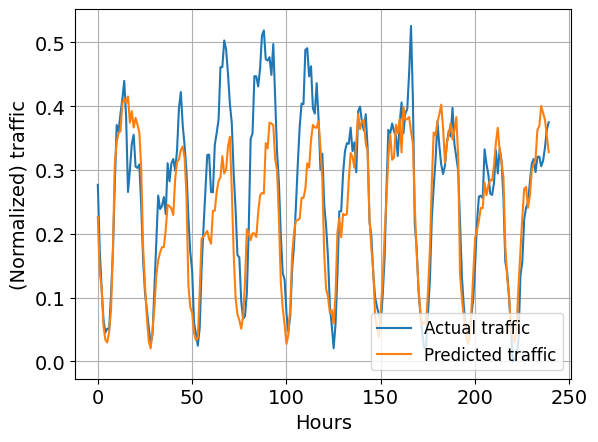

In [13]:
y_pred_ANN = model_NN.predict(X_test)

resfig_NN = 'Results' + '/ANN_pred.png'

mse_ANN, mae_ANN, r2_ANN = performance_eval(y_test, y_pred_ANN, resfig_NN)


# ******* ******* ******* *******  ******* ******* ******* *******
# Now we repeat tasks 2, 3, 4 considering Long-Short-Term-Memory (LSTM) networks instead of ANN
# ******* ******* ******* *******  ******* ******* ******* *******

# Task 5a)

Define function *generatedataset_LSTM()* that takes in input the traffic dataset as created in task 2b) and number of previous days to consider as input for the LSTM prediction, and returns matrix X and output y as numpy ndarrays

(details below)


In [14]:
def generatedataset_LSTM(dataset, lookback_days = 1):
#Inputs:  - dataset: pandas dataframe with traffic profile as loaded above
#         - lookback_days: no. of days that we want to consider as input to perform prediction with LSTM
#Outputs: - return X, y (matrix X and output y are numpy ndarrays)
#         The i-th element of X is a sequence of lookback_days*24 hourly traffic traces, and the corresponding
#         i-th element of y is the predicted traffic for the following hour

    unrolled_data = np.array(dataset).reshape(-1, 1)
############# ADD YOUR CODE BELOW #############

    X, y = [], []

    lookback_samples = int(lookback_days * 24)

    for i in range(len(unrolled_data)):
        last_sample = i + lookback_samples
        if last_sample > len(unrolled_data) - 1:
            break
        X.append(unrolled_data[i : last_sample])
        y.append(unrolled_data[last_sample])

    X = np.array(X)
    y = np.array(y)


    return X, y


# Task 5b)

Call function *generatedataset_LSTM()* considering the dataframe created in task 2b) and **3 days "lookback"**, and store outputs in variables XL, yL.

For each element in (XL, yL) verify that the dataset is consistent

Hint:
- to have consistent dataset, the value of yL for the i-th pair in (XL,yL) should coincide with the last value of XL in the (i+1)-th pair in (XL,yL)

(code is already given below)

In [15]:
lbd = 3 #F: = lookback_days
XL, yL = generatedataset_LSTM(dataframe, lbd)

check_t = 0
for t in range(len(yL)-1): #F: -1 as the last value of yL is not included in XL
    if yL[t] != XL[t+1][-1]: #F: [t+1][-1] will take the last (=-1) value of XL in the (t+1) element
        print('values of XL and yL for time t={} do not coincide'.format(t))
        check_t += 1
print('Number of failed checks: '+str(check_t))


Number of failed checks: 0


# Task 6a)

Define function *train_test_split_LSTM()* that takes in input the dataset (X,y), the desired amount of test data (number of hours/samples) and the desired gap between train and test sets, and splits (X,y) into train/test sets **with samples ordered chronologically**

Before returning train and test sets, X and y should be normalized so as to be in [0,1] range **avoiding data leakage**

**N.B. X and y should be normalized independently**

Hints:

- Note that our dataset includes one sample per hour but gap provided in input is expressed in no. of days
- You can take inspiration from notebook *split-sets-task-6a*
- Use *MinMaxScaler* from *sklearn.preprocessing* to scale data between 0 and 1 https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html


In [16]:
def train_test_split_LSTM(X, y, test_hours, day_gap):
#Inputs:  - X: matrix of features (for each element, a series of traffic values of length lookback_days*24)
#         - y: outputs vector (for each element, the value of traffic to be predicted for the next hour)
#         - test_hours: number of hours/samples in (X,y) to include in the test set
#         - day_gap: no. of days that we want to consider as separation between train and test sets
#               Setting day_gap=0 means that 1st element of y_test is the traffic for subsequent hour wrt last element in y_train
#               Note that with day_gap=0, we will include in X_test traffic info used as output in training phase (they are also in y_train)
#Outputs: return X_train, X_test, y_train, y_test

    # Split (X,y) into train and test set, putting into test set a number of samples (hours) equal to test_hours in input
    # and in training set the remaining sample BUT.... "mind the gap!" (day_gap)
    ############# ADD YOUR CODE BELOW #############
    gap = int(day_gap*24)
    test_samples = test_hours
    train_samples = X.shape[0] - test_hours - gap

    test_samples_start = int(train_samples + gap) #F: int() is needed to convert float to int, needed for indexing

    X_train = X[: train_samples]
    y_train = y[: train_samples]

    X_test = X[test_samples_start :]
    y_test = y[test_samples_start :]


    ####################################################
    # scale train/test sets (both inputs and outputs) without data leakage!
    scaler = MinMaxScaler(feature_range=(0, 1)) #F: The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data
    X_train[:,:,0] = scaler.fit_transform(X_train[:,:,0])
    X_test[:,:,0] = scaler.transform(X_test[:,:,0])


    y_train = np.reshape(y_train, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))

    y_train = scaler.fit_transform(y_train)
    y_test = scaler.transform(y_test)

    return X_train, X_test, y_train, y_test



# Task 6b)

Call function *train_test_split_LSTM()* and generate new training/test sets with the same size of test set used in task 3b) for ANN and gap between train and test sets that provides no overlap between train/test (i.e., **gap = lookback_days**)

Verify dimensions of train, test and whole datasets.
Verify the min and max values of features are different between unscaled dataset (X,y) and scaled training/test sets.

(code is already given below)

In [17]:
#n_hours = 240 #F: alredy defined above

desired_gap = lbd #F: in number of days (can be fractional, but such that desired_gap*24 is integer)
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split_LSTM(XL, yL, n_hours, desired_gap)

print(XL.shape)
print(yL.shape)
print(X_train_LSTM.shape)
print(y_train_LSTM.shape)
print(X_test_LSTM.shape)
print(y_test_LSTM.shape)

# verify that features scaling is working
for i in range(XL.shape[1]):
    print('******** Feature {} ********'.format(i))
    minvalue = XL[:,i].min()
    maxvalue = XL[:,i].max()
    print('Min value (unscaled dataset) {}'.format(minvalue))
    print('Max value (unscaled dataset) {}'.format(maxvalue))
    minvalue_train = X_train_LSTM[:,i].min()
    maxvalue_train = X_train_LSTM[:,i].max()
    print('Min value (scaled training set) {}'.format(minvalue_train))
    print('Max value (scaled training set) {}'.format(maxvalue_train))
    minvalue_test = X_test_LSTM[:,i].min()
    maxvalue_test = X_test_LSTM[:,i].max()
    print('Min value (scaled test set) {}'.format(minvalue_test))
    print('Max value (scaled test set) {}'.format(maxvalue_test))

print('****************************************************************')
print('******** Target value (y) ********')
miny = yL[:].min()
maxy = yL[:].max()
print('Min y value (unscaled dataset) {}'.format(miny))
print('Max y value (unscaled dataset) {}'.format(maxy))
miny_train = y_train_LSTM[:].min()
maxy_train = y_train_LSTM[:].max()
print('Min value (scaled training set) {}'.format(miny_train))
print('Max value (scaled training set) {}'.format(maxy_train))
miny_test = y_test_LSTM[:].min()
maxy_test = y_test_LSTM[:].max()
print('Min value (scaled test set) {}'.format(miny_test))
print('Max value (scaled test set) {}'.format(maxy_test))

(1392, 72, 1)
(1392, 1)
(1080, 72, 1)
(1080, 1)
(240, 72, 1)
(240, 1)
******** Feature 0 ********
Min value (unscaled dataset) 0.0
Max value (unscaled dataset) 74.9688630742
Min value (scaled training set) 0.0
Max value (scaled training set) 0.9999999999999998
Min value (scaled test set) 0.0011710723491695219
Max value (scaled test set) 0.5257552908362866
******** Feature 1 ********
Min value (unscaled dataset) 0.0
Max value (unscaled dataset) 74.9688630742
Min value (scaled training set) 0.0
Max value (scaled training set) 0.9999999999999998
Min value (scaled test set) 0.0011710723491695219
Max value (scaled test set) 0.5257552908362866
******** Feature 2 ********
Min value (unscaled dataset) 0.0
Max value (unscaled dataset) 74.9688630742
Min value (scaled training set) 0.0
Max value (scaled training set) 0.9999999999999998
Min value (scaled test set) 0.0011710723491695219
Max value (scaled test set) 0.5257552908362866
******** Feature 3 ********
Min value (unscaled dataset) 0.0
Max v

# Task 7a)

Build a LSTM with default activation function, 2 hidden layers with [7, 3] neurons, respectively

Print final TRAINING MSE and training duration, and save a figure with model structure. Figure with model structure should be saved as .png file in subfolder 'Results'

**N.B. The LSTM output layer is a single neuron that should output a real value (no activation function)**

Hints:
- We are solving a REGRESSION problem --> use MSE as loss metric
- Use *Sequential* from *tensorflow.keras.models*, *LSTM* from *tensorflow.keras.layers*, *mean_squared_error* from *sklearn.metrics*, *plot_model* from *tensorflow.keras.utils*
- Note that LSTM requires to know the length of input sequence explicitly (lookback days defined in task 5a)
- LSTM documentation at: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [18]:
layers = 2
neurons = [7,3]

res_folder = 'Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

structure_figure_LSTM = res_folder + '/LSTM_structure.png'

print('fitting model with {} layer(s) and {} neurons'.format(layers,neurons))

model_LSTM = Sequential()

#F: now you should stack LSTM layers as hidden layers and add the final layer as a Dense layer (like we did for ANNs previously)
############# ADD YOUR CODE BELOW #############

model_LSTM.add(LSTM(neurons[0], return_sequences=True, input_shape=(int(lbd * 24), 1))) #F: see also https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
#F: N.B.----------> new versions of LSTM: apparently you can now avoid specifying input_shape

model_LSTM.add(LSTM(neurons[1], return_sequences=False)) #F: see also https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

model_LSTM.add(Dense(1))

model_LSTM.compile(optimizer = "adam", loss = 'mean_squared_error')

t0 = time.time()
t0string = time.ctime(t0)
print('Start: '+str(t0string))
model_LSTM.fit(X_train_LSTM, y_train_LSTM, epochs=50, verbose=False)
t1 = time.time()
t1string=time.ctime(t1)
print('End: '+str(t1string))
training_time_LSTM = round(t1 - t0,2)
print('LSTM training duration [s]: {}'.format(training_time_LSTM))


y_hat_LSTM = model_LSTM.predict(X_train_LSTM)

mse_LSTM = mean_squared_error(y_train_LSTM, y_hat_LSTM)

print('LSTM Training MSE: {}'.format(mse_LSTM))

plot_model(model_LSTM, structure_figure_LSTM, show_shapes=True)

model_LSTM.summary() #F: this is another way to show model characteristics




fitting model with 2 layer(s) and [7, 3] neurons
Start: Mon May 20 13:41:22 2024
End: Mon May 20 13:42:29 2024
LSTM training duration [s]: 66.67
34/34 [==============================] - 1s 8ms/step
LSTM Training MSE: 0.003908001626132218
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 7)             252       
                                                                 
 lstm_1 (LSTM)               (None, 3)                 132       
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 388 (1.52 KB)
Trainable params: 388 (1.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Task 7b)

Perform prediction using LSTM model trained in task 7a), then call function *performance_eval()* to print/save results

(code is already given below)

8/8 [==============================] - 0s 10ms/step
MSE: 0.0020748085926358137
MAE: 0.03659186601936586
R2 score: 0.8822013107723534


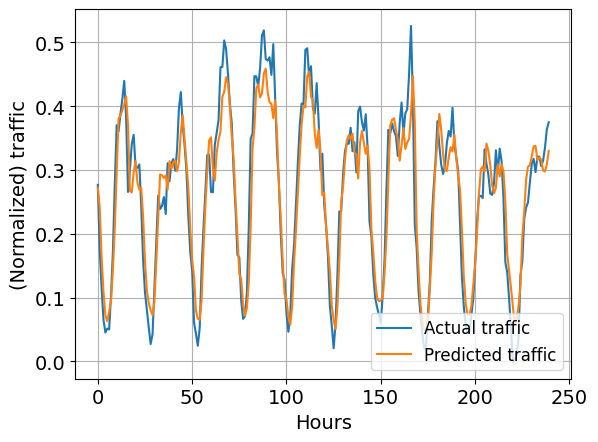

In [19]:
resfig_LSTM = 'Results' + '/LSTM_pred.png'

y_pred_LSTM = model_LSTM.predict(X_test_LSTM)

mse_LSTM, mae_LSTM, r2_LSTM = performance_eval(y_test_LSTM, y_pred_LSTM, resfig_LSTM)

# Tasks 8a)-8b)-8c) - HOMEWORK (max 2 points)



# Task 8a)
Calculate min and max traffic values of the dataframe created in task 2b) and scaled ground-truth, ANN-predicted and LSTM-predicted traffic traces (test set) so as to have maximum traffic = 1 Gbit/s (so far we have worked with a dataset expressed in CDR units). Then, plot the three traffic traces in a single plot

Hints:
- the dataframe in task 2b) is called *dataframe*
- recall that traffic traces had been normalized so as to have them in [0,1] range
- you may need to rename (some of the) variables *y_test*, *y_pred_ANN* and *y_pred_LSTM* below with the names you have used for ground truth and predicted traffic


Minimum traffic value: 24.779079336859997
Maximum traffic value: 152.19921217209998
Scaled Ground-Truth Traffic (min, max): (162.20276312479672, 602.9655937396016)
Scaled ANN-Predicted Traffic (min, max): (179.95579528808594, 510.4286804199219)
Scaled LSTM-Predicted Traffic (min, max): (202.51321411132812, 546.9776611328125)


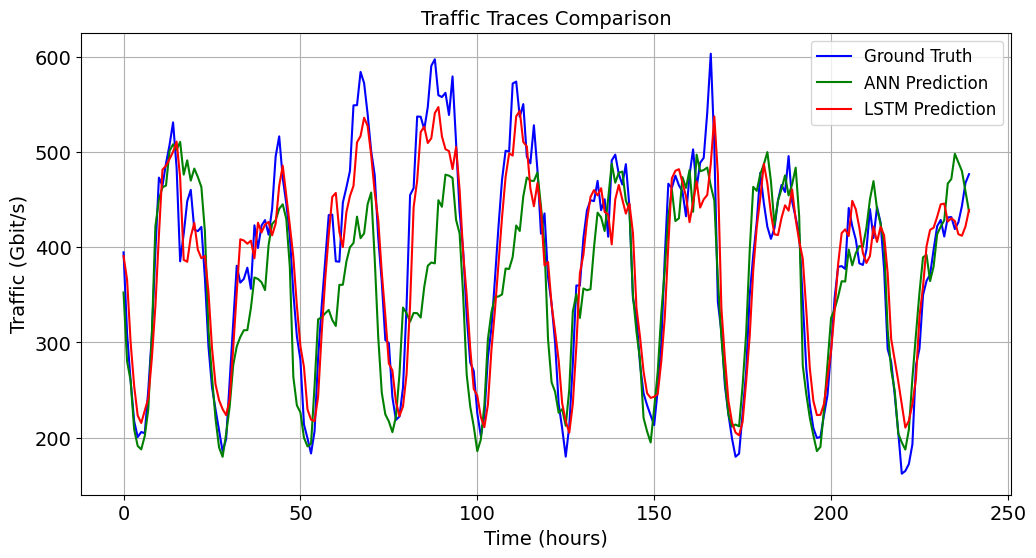

In [28]:
############# ADD YOUR CODE BELOW #############

# Calculate min and max traffic values from the dataframe
min_traffic = dataframe.min().min()
#print(min_traffic)
max_traffic = dataframe.max().max()
#print(max_traffic)

print(f"Minimum traffic value: {min_traffic}")
print(f"Maximum traffic value: {max_traffic}")

# Convert normalized traffic values to original [min, max] range
y_unscaled = y_test * (max_traffic - min_traffic) + min_traffic # Convert normalized y_test to original scale
y_pred_ANN_unscaled = y_pred_ANN * (max_traffic - min_traffic) + min_traffic # Convert normalized y_pred_ANN to original scale
y_pred_LSTM_unscaled = y_pred_LSTM * (max_traffic - min_traffic) + min_traffic # Convert normalized y_pred_LSTM to original scale


# Scale traffic values to Gbit/s (assuming max_traffic should be scaled to 1 Gbit/s)
max_traffic_gbps = 1000

y_test_scaled = y_unscaled * (max_traffic_gbps / max_traffic)
y_pred_ANN_scaled = y_pred_ANN_unscaled * (max_traffic_gbps / max_traffic)
y_pred_LSTM_scaled = y_pred_LSTM_unscaled * (max_traffic_gbps / max_traffic)

# Verify scaled values
print(f"Scaled Ground-Truth Traffic (min, max): ({y_test_scaled.min()}, {y_test_scaled.max()})")
print(f"Scaled ANN-Predicted Traffic (min, max): ({y_pred_ANN_scaled.min()}, {y_pred_ANN_scaled.max()})")
print(f"Scaled LSTM-Predicted Traffic (min, max): ({y_pred_LSTM_scaled.min()}, {y_pred_LSTM_scaled.max()})")

# Plotting the traffic traces
plt.figure(figsize=(12, 6))

plt.plot(y_test_scaled, label='Ground Truth', color='blue')
plt.plot(y_pred_ANN_scaled, label='ANN Prediction', color='green')
plt.plot(y_pred_LSTM_scaled, label='LSTM Prediction', color='red')

plt.title('Traffic Traces Comparison')
plt.xlabel('Time (hours)')
plt.ylabel('Traffic (Gbit/s)')
plt.legend()
plt.grid(True)
plt.show()

In this plot is possible to notice the comparison between the LSTM prediction and the ANN prediction. In particular can be seen that the LSTM prediction follows more accurately the ground truth.

# Task 8b)
Define function *evaluate_cost()* that takes in input ground-truth, ANN-predicted and LSTM-predicted traffic traces (scaled as in task 8a) and two cost parameters *alpha* and *beta* for over/under-provisioning and returns cost of over/under-provisioning for the ANN and LSTM cases, assuming a given resource allocation policy (details below)

Hint:
- you can use *math.ceil* (*import math*) to round up numbers


In [26]:
def evaluate_cost(ytrue, ypredANN, ypredLSTM, alpha, beta):
#Inputs:  - ytrue: ground-truth traffic
#         - ypredANN: ANN-predicted traffic
#         - ypredLSTM: LSTM-predicted traffic
#         - alpha, beta: scalar parameters that weight over- and under-provisioning costs, respectively
#Outputs: return costANN, costLSTM
#     To generate costs above, assume that an operator allocates interfaces with 100 Mbit/s granularity
#     (e.g., if predicted traffic is 440 Mbit/s, then 5 interfaces are needed).
#     Then, over/under-provisioning costs are calculated weighting the difference between ground truth
#     and predicted interfaces with parameters alpha and beta in input used to weigh over/under-provisioning.
#     N.B. Over-provisioning cost can be due to (e.g.) unnecessary power consumption;
#     under-provisioning cost can be due to (e.g.) blocked traffic
############# ADD YOUR CODE BELOW #############

    # Convert traffic values to the number of required interfaces (each interface is 100 Mbit/s)
    ytrue_interfaces = np.ceil(ytrue/100)  # 1 Gbit/s = 1000 Mbit/s, so 100 Mbit/s = 0.1 Gbit/s; 10 interfaces per Gbit/s
    ypredANN_interfaces = np.ceil(ypredANN/100)
    ypredLSTM_interfaces = np.ceil(ypredLSTM/100)

    # Calculate over-provisioning and under-provisioning
    over_provisioning_ANN = np.maximum(0, ypredANN_interfaces - ytrue_interfaces)
    under_provisioning_ANN = np.maximum(0, ytrue_interfaces - ypredANN_interfaces)

    over_provisioning_LSTM = np.maximum(0, ypredLSTM_interfaces - ytrue_interfaces)
    under_provisioning_LSTM = np.maximum(0, ytrue_interfaces - ypredLSTM_interfaces)

    # Calculate total costs
    cost_ANN = alpha * over_provisioning_ANN.sum() + beta * under_provisioning_ANN.sum()
    cost_LSTM = alpha * over_provisioning_LSTM.sum() + beta * under_provisioning_LSTM.sum()

    return cost_ANN, cost_LSTM

# Task 8c)

Use function *evaluate_cost()* with given over/under-provisioning cost weights using ground-truth, ANN-predicted and LSTM-predicted traffic traces above; plot results in a 3D graph


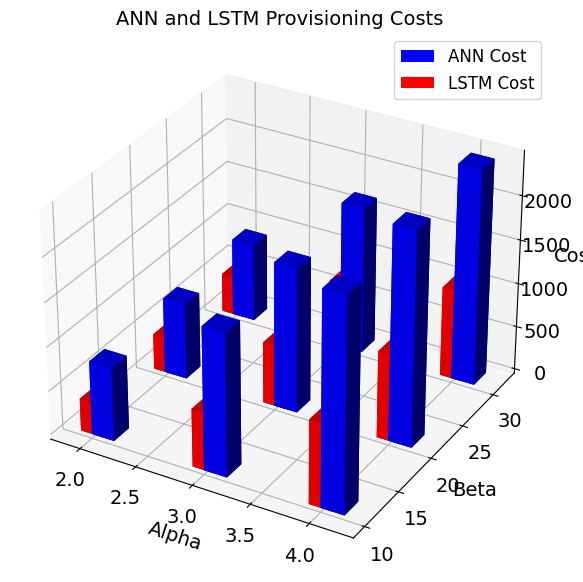

In [27]:
# ---------------------------- PLOT ---------------------------- #

# Define ranges for alpha and beta
alpha_list = [2,3,4]
beta_list = [10,20,30]

# Create a grid to store costs
cost_ANN_grid = np.zeros((len(alpha_list), len(beta_list)))
cost_LSTM_grid = np.zeros((len(alpha_list), len(beta_list)))

# Compute costs for each combination of alpha and beta
for i, alpha in enumerate(alpha_list):
    for j, beta in enumerate(beta_list):
        cost_ANN, cost_LSTM = evaluate_cost(y_test_scaled, y_pred_ANN_scaled, y_pred_LSTM_scaled, alpha, beta)
        # Update the grids
        cost_ANN_grid[i, j] = cost_ANN
        cost_LSTM_grid[i, j] = cost_LSTM

# Plotting results in a 3D bar plot
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

# Prepare data for 3D bar plot
alpha_mesh, beta_mesh = np.meshgrid(alpha_list, beta_list) # Create a meshgrid of alpha and beta values
alpha_mesh = alpha_mesh.flatten() # Flatten the alpha meshgrid for plotting
beta_mesh = beta_mesh.flatten() # Flatten the beta meshgrid for plotting
Z_ANN = np.zeros_like(cost_ANN_grid.flatten())
Z_LSTM = np.zeros_like(cost_LSTM_grid.flatten())
dx = 0.2 # Width of the bars
dy = 2 # Depth of the bars

dz_ANN = cost_ANN_grid.flatten() # Flatten the ANN cost grid for plotting
dz_LSTM = cost_LSTM_grid.flatten() # Flatten the LSTM cost grid for plotting

# Plot ANN costs
ax.bar3d(alpha_mesh, beta_mesh, Z_ANN, dx, dy, dz_ANN, shade=True, color='blue', label='ANN Cost')
b1 = plt.Rectangle((0, 0), 1, 1, fc="blue") # Create a blue legend entry for ANN costs

# Plot LSTM costs
ax.bar3d(alpha_mesh-0.1 , beta_mesh, Z_LSTM, dx, dy, dz_LSTM, shade=True, color='red', label='LSTM Cost')
b2 = plt.Rectangle((0, 0), 1, 1, fc="red")# Create a red legend entry for LSTM costs


# Set labels
ax.set_title('ANN and LSTM Provisioning Costs')
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Cost')
ax.legend([b1, b2], ['ANN Cost', 'LSTM Cost'])

plt.show()


Underestimating and overestimating the traffic are both two crucial problems; in particular for an operator if the traffic is overestimated can happen that will be opened a number of interfaces that is higher then the ones that are needed, on the other hand if the traffic is understimated the number of opened interfaces may not be sufficient. By weighting the cost associated to this two events using two different parameters alpha and beta and plotting a 3D plot where we can see the evolution of the cost depending on these two parameters, can be observed that in general under estimation of the traffic has a greater impact on costs and at the same time using LSTM instead of ANN, because of the fact that is a better estimator, the cost appears to be way lower.